# <div style='text-align:center'> Amazon review

In [1]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn import naive_bayes
import warnings; warnings.simplefilter('ignore')

In [2]:
data = pd.read_json('reviews_Digital_Music_5.json', lines=True)

In [3]:
data.head(5)

,asin,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime
0,5555991584,"[3, 3]",5,"It's hard to believe ""Memory of Trees"" came ou...","09 12, 2006",A3EBHHCZO6V2A4,"Amaranth ""music fan""",Enya's last great album,1158019200
1,5555991584,"[0, 0]",5,"A clasically-styled and introverted album, Mem...","06 3, 2001",AZPWAXJG9OJXV,bethtexas,Enya at her most elegant,991526400
2,5555991584,"[2, 2]",5,I never thought Enya would reach the sublime h...,"07 14, 2003",A38IRL0X2T4DPF,bob turnley,The best so far,1058140800
3,5555991584,"[1, 1]",5,This is the third review of an irish album I w...,"05 3, 2000",A22IK3I6U76GX0,Calle,Ireland produces good music.,957312000
4,5555991584,"[1, 1]",4,"Enya, despite being a successful recording art...","01 17, 2008",A1AISPOIIHTHXX,"Cloud ""...""",4.5; music to dream to,1200528000


## 1. Only consider the *reviewText* for analysis. 

In [4]:
data_1 = data[['overall', 'reviewText']]
data_1.head(5)

,overall,reviewText
0,5,"It's hard to believe ""Memory of Trees"" came ou..."
1,5,"A clasically-styled and introverted album, Mem..."
2,5,I never thought Enya would reach the sublime h...
3,5,This is the third review of an irish album I w...
4,4,"Enya, despite being a successful recording art..."


In [5]:
stopset = set(stopwords.words('english'))
vectorizer = TfidfVectorizer(use_idf=True, lowercase=True, strip_accents='ascii', stop_words=stopset)

### Turn the text into useful features with Tfidf and stopwords(words to omitt) in English from the nltk corpus

label the sentiments by the *overall* feature where:
+ Positive is **1** according to overall = 1, 2
+ Neutral is **0** according to overall = 3
+ Negative is **-1** according to overall = 4, 5

In [6]:
data_1.replace([1,2],-1, inplace=True)
data_1.replace([3],0, inplace=True)
data_1.replace([4,5],1, inplace=True)

In [7]:
y = data_1.overall

In [8]:
X = vectorizer.fit_transform(data_1.reviewText)

In [9]:
X.shape, y.shape

((64706, 116268), (64706,))

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)

In [11]:
clf = naive_bayes.MultinomialNB()
clf.fit(X_train, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [12]:
from sklearn.metrics import accuracy_score
print('The accuracy when using only reviewText is {:.2f}%'.format(accuracy_score(y_test, clf.predict(X_test))*100))
data_1_result = accuracy_score(y_test, clf.predict(X_test))*100

The accuracy when using only reviewText is 80.52%


In [13]:
import numpy as np
test_review = np.array(['hate it so much'])
test_review_vector = vectorizer.transform(test_review)
print(clf.predict_proba(test_review_vector))
clf.predict(test_review_vector)

[[0.05168319 0.05332577 0.89499105]]


array([1])

## 2. Only consider *summary* for analysis

In [14]:
data_2 = data[['overall', 'summary']]
data_2.head(5)

,overall,summary
0,5,Enya's last great album
1,5,Enya at her most elegant
2,5,The best so far
3,5,Ireland produces good music.
4,4,4.5; music to dream to


In [15]:
data_2.replace([1,2],-1, inplace=True)
data_2.replace([3],0, inplace=True)
data_2.replace([4,5],1, inplace=True)

In [16]:
y = data_2.overall
X = vectorizer.fit_transform(data_2.summary)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)
clf = naive_bayes.MultinomialNB()
clf.fit(X_train, y_train)
print('The accuracy when using only summary is {:.2f}%'.format(accuracy_score(y_test, clf.predict(X_test))*100))
data_2_result = accuracy_score(y_test, clf.predict(X_test))*100

The accuracy when using only summary is 81.21%


# Further investigation

In [17]:
data_2.overall.value_counts()

 1    52116
 0     6789
-1     5801
Name: overall, dtype: int64

In [18]:
import matplotlib.pyplot as plt
 
# Data to plot
labels = ['positive', 'neutral', 'negative']
sizes = data_2.overall.value_counts()
colors = ['gold', 'yellowgreen', 'lightcoral']

# Plot
plt.pie(sizes, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=90)
 
plt.axis('equal')
plt.show()

<Figure size 640x480 with 1 Axes>

This data set is heavily skewed with very large portion of positive features while the negative and neutral features seems balanced.

I propose taking some samples from the positve class for training so that we have balance between classes.

## 3. Using *summary* with balanced classes.

In [19]:
dfa = data_2[data_2['overall'] == 1].sample(6000, random_state=42)
dfb = data_2[data_2['overall'] != 1]

In [20]:
data_3 = dfa.append(dfb, ignore_index=True)
data_3.head(5)

,overall,summary
0,1,the threshold of masters
1,1,Ran Into the Night
2,1,It's not Adrenaline..but hey!
3,1,Beauty beats
4,1,Jimi Hendrix - Are You Experienced?


In [21]:
data_3.overall.value_counts()

 0    6789
 1    6000
-1    5801
Name: overall, dtype: int64

In [22]:
y = data_3.overall
X = vectorizer.fit_transform(data_3.summary)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)
clf = naive_bayes.MultinomialNB()
clf.fit(X_train, y_train)
print('The accuracy when using summary with balanced classes is {:.2f}%'.format(accuracy_score(y_test, clf.predict(X_test))*100))
data_3_result = accuracy_score(y_test, clf.predict(X_test))*100

The accuracy when using summary with balanced classes is 56.43%


## 4. Using *reviewText* with balanced clasess

In [23]:
dfa = data_1[data_1['overall'] == 1].sample(6000, random_state=42)
dfb = data_1[data_1['overall'] != 1]
data_4 = dfa.append(dfb, ignore_index=True)
y = data_4.overall
X = vectorizer.fit_transform(data_4.reviewText)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)
clf = naive_bayes.MultinomialNB()
clf.fit(X_train, y_train)
print('The accuracy when using only reviewText with balanced classes is {:.2f}%'.format(accuracy_score(y_test, clf.predict(X_test))*100))

data_4_result = accuracy_score(y_test, clf.predict(X_test))*100

The accuracy when using only reviewText with balanced classes is 55.22%


# Further investigation

This time I want to use the *helpful* feature 

This feature has the format [a, b] means that there are **a** people over **b** people find that helpful. To make this information more usefull and more intepretable, I will transform it into a single number **c**, where:
<div> c = a - (b-a) = a - b + a = 2a - b </div>
<div> where a is the helpful vote of the review and (b-a) is the unhelpful vote of the review, holding the negative mark </div>

## 5. Using *summary* and *helpful* with balanced classes

In [24]:
data_5 = data[['overall', 'summary', 'helpful']]
data_5.head(5)

,overall,summary,helpful
0,5,Enya's last great album,"[3, 3]"
1,5,Enya at her most elegant,"[0, 0]"
2,5,The best so far,"[2, 2]"
3,5,Ireland produces good music.,"[1, 1]"
4,4,4.5; music to dream to,"[1, 1]"


In [25]:
def convert_helpful(item):
    return 2*item[0] - item[1]

In [26]:
data_5.helpful = data_5.helpful.apply(convert_helpful)
data_5.head()

,overall,summary,helpful
0,5,Enya's last great album,3
1,5,Enya at her most elegant,0
2,5,The best so far,2
3,5,Ireland produces good music.,1
4,4,4.5; music to dream to,1


In [27]:
data_5.helpful = (data_5.helpful - data_5.helpful.mean())/data_5.helpful.std() #stdize data
data_5.helpful = (data_5.helpful - data_5.helpful.min()) / (data_5.helpful.max() - data_5.helpful.min()) #normalize data
data_5.helpful.describe()

count    64706.000000
mean         0.205039
std          0.017351
min          0.000000
25%          0.201626
50%          0.203252
75%          0.204878
max          1.000000
Name: helpful, dtype: float64

balance the classes

In [28]:
data_5.replace([1,2],-1, inplace=True)
data_5.replace([3],0, inplace=True)
data_5.replace([4,5],1, inplace=True)

dfa = data_5[data_5['overall'] == 1].sample(6000, random_state=42)
dfb = data_5[data_5['overall'] != 1]
data_5 = dfa.append(dfb, ignore_index=True)

In [29]:
data_5.describe(include='all')

,overall,summary,helpful
count,18590.000000,18590,18590.000000
unique,NaN,17703,NaN
top,NaN,Disappointing,NaN
freq,NaN,19,NaN
mean,0.010705,NaN,0.201681
std,0.796695,NaN,0.017486
min,-1.000000,NaN,0.000000
25%,-1.000000,NaN,0.200000
50%,0.000000,NaN,0.201626
75%,1.000000,NaN,0.204878


Choose the 75% most helpful reviews to evaluate

In [30]:
df_pos = data_5[data_5.overall == 1].nlargest(4500,'helpful')
df_neu = data_5[data_5.overall == 0].nlargest(4500,'helpful')
df_neg = data_5[data_5.overall == -1].nlargest(4500,'helpful')
data_5 = df_pos.append([df_neu, df_neg], ignore_index=True)

In [31]:
y = data_5.overall
X = vectorizer.fit_transform(data_5.summary)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)
clf = naive_bayes.MultinomialNB()
clf.fit(X_train, y_train)
print('The accuracy when using helpful and summary with balanced classes is {:.2f}%'.format(accuracy_score(y_test, clf.predict(X_test))*100))
data_5_result = accuracy_score(y_test, clf.predict(X_test))*100

The accuracy when using helpful and summary with balanced classes is 55.37%


## 6.  Using *reviewText* and *helpful* with balanced classes

In [32]:
data_6 = data[['overall', 'reviewText', 'helpful']]
data_6.helpful = data_6.helpful.apply(convert_helpful)
data_6.helpful = (data_6.helpful - data_6.helpful.mean())/data_6.helpful.std() #stdize data
data_6.helpful = (data_6.helpful - data_6.helpful.min()) / (data_6.helpful.max() - data_6.helpful.min()) #normalize data
data_6.replace([1,2],-1, inplace=True)
data_6.replace([3],0, inplace=True)
data_6.replace([4,5],1, inplace=True)

dfa = data_6[data_6['overall'] == 1].sample(6000, random_state=42)
dfb = data_6[data_6['overall'] != 1]
data_6 = dfa.append(dfb, ignore_index=True)

df_pos = data_6[data_6.overall == 1].nlargest(4500,'helpful')
df_neu = data_6[data_6.overall == 0].nlargest(4500,'helpful')
df_neg = data_6[data_6.overall == -1].nlargest(4500,'helpful')
data_6 = df_pos.append([df_neu, df_neg], ignore_index=True)

y = data_6.overall
X = vectorizer.fit_transform(data_6.reviewText)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)
clf = naive_bayes.MultinomialNB()
clf.fit(X_train, y_train)
print('The accuracy when using helpful and reviewText with balanced classes is {:.2f}%'.format(accuracy_score(y_test, clf.predict(X_test))*100))
data_6a_result = accuracy_score(y_test, clf.predict(X_test))*100

The accuracy when using helpful and reviewText with balanced classes is 61.67%


We have achieved the highest accuracy so far when we balanced down the classes. To take advantage of the helpful, we might want to try to filter sample with lower portion than 75% most helpful reviews. We will try with 50% and 25%.

### 50% most helpful

In [33]:
data_6 = data[['overall', 'reviewText', 'helpful']]
data_6.helpful = data_6.helpful.apply(convert_helpful)
data_6.helpful = (data_6.helpful - data_6.helpful.mean())/data_6.helpful.std() #stdize data
data_6.helpful = (data_6.helpful - data_6.helpful.min()) / (data_6.helpful.max() - data_6.helpful.min()) #normalize data
data_6.replace([1,2],-1, inplace=True)
data_6.replace([3],0, inplace=True)
data_6.replace([4,5],1, inplace=True)

df_pos = data_6[data_6.overall == 1].nlargest(3000,'helpful')
df_neu = data_6[data_6.overall == 0].nlargest(3000,'helpful')
df_neg = data_6[data_6.overall == -1].nlargest(3000,'helpful')
data_6 = df_pos.append([df_neu, df_neg], ignore_index=True)

y = data_6.overall
X = vectorizer.fit_transform(data_6.reviewText)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)
clf = naive_bayes.MultinomialNB()
clf.fit(X_train, y_train)
print('The accuracy when using 50% most helpful and reviewText with balanced classes is {:.2f}%'.format(accuracy_score(y_test, clf.predict(X_test))*100))
data_6b_result = accuracy_score(y_test, clf.predict(X_test))*100

The accuracy when using 50% most helpful and reviewText with balanced classes is 63.89%


The accuracy increases slightly. Let s try with 25% most helpful to see the result

### 25% most helpful

In [34]:
data_6 = data[['overall', 'reviewText', 'helpful']]
data_6.helpful = data_6.helpful.apply(convert_helpful)
data_6.helpful = (data_6.helpful - data_6.helpful.mean())/data_6.helpful.std() #stdize data
data_6.helpful = (data_6.helpful - data_6.helpful.min()) / (data_6.helpful.max() - data_6.helpful.min()) #normalize data
data_6.replace([1,2],-1, inplace=True)
data_6.replace([3],0, inplace=True)
data_6.replace([4,5],1, inplace=True)

df_pos = data_6[data_6.overall == 1].nlargest(1500,'helpful')
df_neu = data_6[data_6.overall == 0].nlargest(1500,'helpful')
df_neg = data_6[data_6.overall == -1].nlargest(1500,'helpful')
data_6 = df_pos.append([df_neu, df_neg], ignore_index=True)

y = data_6.overall
X = vectorizer.fit_transform(data_6.reviewText)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)
clf = naive_bayes.MultinomialNB()
clf.fit(X_train, y_train)
print('The accuracy when using 25% most helpful and reviewText with balanced classes is {:.2f}%'.format(accuracy_score(y_test, clf.predict(X_test))*100))
data_6c_result = accuracy_score(y_test, clf.predict(X_test))*100

The accuracy when using 25% most helpful and reviewText with balanced classes is 64.89%


In [35]:
test_review = np.array(['hate it so much'])
test_review_vector = vectorizer.transform(test_review)
print(clf.predict_proba(test_review_vector))
clf.predict(test_review_vector)

[[0.50295583 0.34548924 0.15155493]]


array([-1])

As we can see, for the test review we input, the first classifier that only uses *reviewText* with imbalanced classes classifies this as **positive** which is incorrect. The last classifier classifies it as **negative**.

In [36]:
test_review = np.array(['this is good Ok'])
test_review_vector = vectorizer.transform(test_review)
print(clf.predict_proba(test_review_vector))
clf.predict(test_review_vector)

[[0.41706053 0.42887648 0.154063  ]]


array([0])

A classified **neutral** review

In [37]:
test_review = np.array(['listen to this song again and again '])
test_review_vector = vectorizer.transform(test_review)
print(clf.predict_proba(test_review_vector))
clf.predict(test_review_vector)

[[0.32353395 0.32074981 0.35571624]]


array([1])

A classified **positve** review

In [38]:
result = [data_1_result, data_2_result, data_3_result, data_4_result, data_5_result, data_6a_result, data_6b_result, data_6c_result]

In [39]:
label =['only reviewText', 
   'only summary', 
   'summary with balanced classes', 
   'reviewText with balanced classes',
   'summary + 75% helpful with balanced classes', 
   'reviewText + 75% helpful with balanced classes', 
   'reviewText + 50% helpful with balanced classes',
   'reviewText + 25% helpful with balanced classes']

In [40]:
df_result = pd.DataFrame({'label': label, 'result': result})
df_result.index = df_result['label']
df_result.drop(columns = 'label', inplace=True)

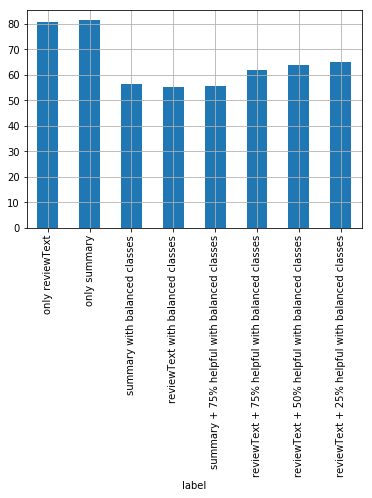

In [41]:
df_result.plot(kind='bar', grid=True, legend=False)

From the result, conclusions could be drawn:
+ class imbalance affects the result but doesn't perform well.
+ when classes are balanced, using *helpful* feature with stricter filter helps the result.